# Training RL Model on SageMaker

This notebook demonstrates how to train a reinforcement learning (RL) model using SageMaker. We'll initialize the SageMaker session, set up the environment for training, define the necessary S3 bucket and Docker image, and then proceed with the training job.

In [1]:
import boto3
import sagemaker
from sagemaker.estimator import Estimator
from sagemaker.session import Session
from sagemaker.session import get_execution_role
import time
import os


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


We start by importing essential libraries:

- boto3 and sagemaker are used to interact with AWS services.
- Estimator, Session, and get_execution_role are required for setting up the SageMaker environment.
- os and time are standard Python libraries for system operations and time tracking.

### Initialize SageMaker Session

Here, we initialize the SageMaker session and retrieve the appropriate execution role using get_execution_role().
- The S3 bucket (sumofiles-reinvent2024) is where the model artifacts will be stored.
- The ecr_image_uri is the URI of the Docker image that contains the RL environment and is stored in Elastic Container Registry (ECR).

In [2]:
# Initialize SageMaker session
sagemaker_session = sagemaker.Session()
s3_client = boto3.client('s3')

# Get the execution role for SageMaker
role = get_execution_role()

# Define your S3 bucket and prefixes
s3_bucket = 'sumofiles-reinvent2024'

# Define the Docker image URI from ECR
ecr_image_uri = '196370667828.dkr.ecr.us-east-1.amazonaws.com/my-model-image:latest'


We define the environment variables that will be passed to the training script.
- PROCESS_TYPE is set to 'TRAIN' to specify that the job is for training.
- The S3_BUCKET is provided as part of the environment to store training artifacts.

In [3]:
# Environment variables for training
train_env = {
    'PROCESS_TYPE': 'TRAIN',
    'S3_BUCKET': s3_bucket
}

Training a good RL model takes a while, so before we run our smaller 10 episode model, let's view the output plots of the model that we will be using later for testing. 

Displaying image: trained_model_plots/delay.png


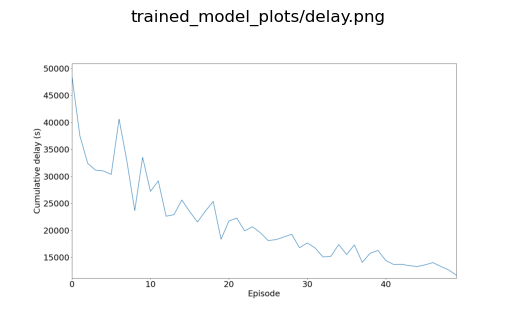

Displaying image: trained_model_plots/queue.png


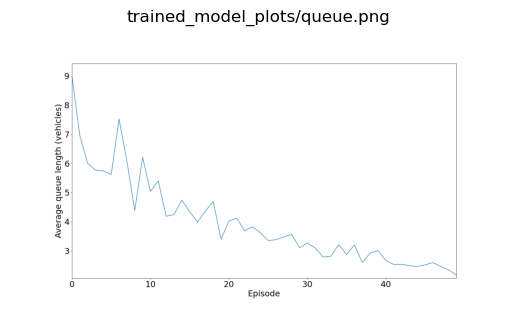

Displaying image: trained_model_plots/reward.png


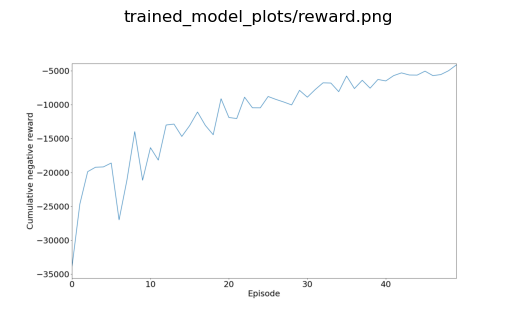

In [4]:
from PIL import Image
import io
import matplotlib.pyplot as plt

# Initialize S3 client
s3_client = boto3.client('s3')

# Function to list and display images from S3
def display_s3_images(bucket, prefix):
    response = s3_client.list_objects_v2(Bucket=bucket, Prefix=prefix)
    if 'Contents' in response:
        for obj in response['Contents']:
            key = obj['Key']
            if key.endswith('.png'):  # Filter for PNG images
                print(f"Displaying image: {key}")
                
                # Get the image from S3
                img_obj = s3_client.get_object(Bucket=bucket, Key=key)
                img_data = img_obj['Body'].read()
                
                # Display the image using PIL and matplotlib
                image = Image.open(io.BytesIO(img_data))
                plt.figure()
                plt.imshow(image)
                plt.axis('off')  # Hide the axes
                plt.title(key)
                plt.show()
    else:
        print(f'No objects found in s3://{bucket}/{prefix}')

# Define the S3 bucket and prefix for the folder
s3_bucket = 'sumofiles-reinvent2024'
s3_prefix = 'trained_model_plots/'  # Folder where the images are stored

# Display images from the oldplots/ folder
display_s3_images(s3_bucket, s3_prefix)


We are ready to train our own model. 

We create an RL Estimator, which is a SageMaker-specific class used for training RL models. Key parameters include:

- entry_point: The Python script that will be executed to start the training.
- image_uri: The Docker image URI containing the RL environment.
- toolKit and toolkit_version: Specify the RL toolkit and its version (Coach in this case).
- framework: Defines the machine learning framework (TensorFlow).
- instance_type: Specifies the type of EC2 instance for training (a GPU-enabled instance in this case).
- environment: The environment variables, including the S3 bucket and process type.
- instance_count: Specifies how many instances to use for training.

In [5]:
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

rl_estimator = RLEstimator(
    entry_point="sagemaker_train.py",  # Adjust to your script name
    image_uri=ecr_image_uri,
    toolkit=RLToolkit.COACH,
    toolkit_version='0.11.1',
    framework=RLFramework.TENSORFLOW,
    role=role,
    instance_type='ml.c5.4xlarge',
    instance_count = 1,
    environment=train_env,
)

Parameter `image_uri` is specified, `toolkit`, `toolkit_version`, `framework` are going to be ignored when choosing the image.


In [6]:
# Start the training job
rl_estimator.fit()

INFO:sagemaker:Creating training-job with name: my-model-image-2024-10-07-08-21-52-608


2024-10-07 08:21:54 Starting - Starting the training job...
2024-10-07 08:22:09 Starting - Preparing the instances for training...
2024-10-07 08:22:46 Downloading - Downloading the training image..................
2024-10-07 08:25:33 Training - Training image download completed. Training in progress..Starting training process...

2024-10-07 08:38:07 Uploading - Uploading generated training model/opt/conda/envs/tf_gpu/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
Created main directory: models
Created model directory: models/model_1
----- Episode 1 of 10
 Retrying in 1 seconds
Simulating...
Total reward: -47103.0 - Epsilon: 1.0
  warnings.warn(warning, Pytho

Let's take a look at our plots vs the trained model ones. You can see that the delay is still alot bigger if we just use 10 episodes. 

Displaying image: plots/delay.png


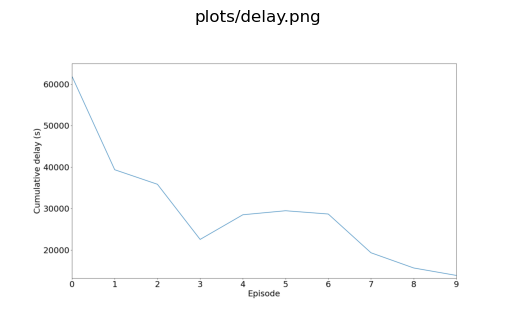

Displaying image: plots/queue.png


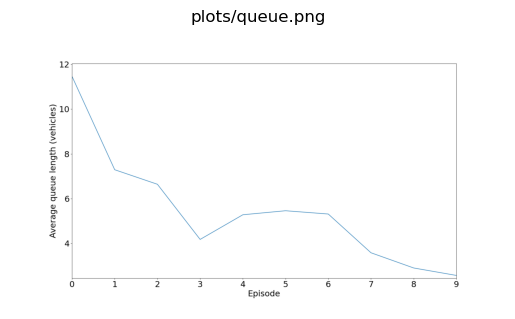

Displaying image: plots/reward.png


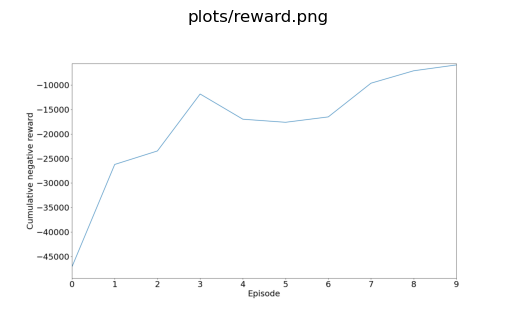

In [7]:
s3_prefix_our_model = 'plots/'

display_s3_images(s3_bucket, s3_prefix_our_model)